In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from matplotlib import pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

In [4]:
root = '/content'
train_set = datasets.FashionMNIST(
    root,
    train=True,
    transform=transform,
    download=True
)
test_set = datasets.FashionMNIST(
    root,
    train=False,
    transform=transform,
    download=True
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15748928.27it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268110.40it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4945623.25it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5455350.43it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [5]:
batch_size = 128

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
class VGG(nn.Module):
    def __init__(self, arch, num_classes=10):
        super(VGG, self).__init__()
        conv_blks = []
        for num_convs, out_channels in arch:
            conv_blks.append(self.vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes)
        )

    def vgg_block(self, num_convs, out_channels):
        layers = []
        for _ in range(num_convs):
            layers.append(nn.LazyConv2d(out_channels, 3, padding=1))
            layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2, stride=2))

        return nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [7]:
arch_sumary = [(1,64), (1,128), (2,256), (2,512), (2,512)]
model_for_summary = VGG(arch_sumary).to(device)
summary(model_for_summary, (1, 224, 224))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

In [8]:
input = torch.randn(1, 1, 224, 224).float().to(device)
out = model_for_summary(input)
print(out)

tensor([[-0.0030,  0.0026, -0.0038, -0.0098, -0.0015, -0.0081, -0.0014,  0.0002,
          0.0070, -0.0062]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [9]:
def train_run_epoch(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    return avg_loss

In [10]:
def test_run_epoch(model, device, test_loader):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            pred = output.argmax(1)
            correct += pred.eq(target).sum().item()

            total_loss += loss.item()

        accuracy = correct / len(test_set)
        avg_loss = total_loss / len(test_loader)

    return accuracy, avg_loss

In [11]:
def train(model, device, train_loder, test_loader, optimizer, criterion, num_epochs):
    train_avg_losses = []
    test_avg_losses = []
    accuracies = []

    for epoch in range(1, num_epochs+1):
        print(f"Epoch [{epoch}/{num_epochs}]")

        train_avg_loss = train_run_epoch(model, device, train_loader, optimizer, criterion)
        train_avg_losses.append(train_avg_loss)
        print(f"Average Train Loss = {train_avg_loss:.6f}")

        accuracy, test_avg_loss = test_run_epoch(model, device, test_loader)
        test_avg_losses.append(test_avg_loss)
        accuracies.append(accuracy)
        print(f"Average Test Loss = {test_avg_loss:.6f}")
        print(f"Test Accuracy = {accuracy:.2f}")
        print()

    return train_avg_losses, test_avg_losses, accuracies

In [19]:
num_epochs = 10
learning_rate = 0.08
arch = [(1,16), (1,32), (2,64), (2,128), (2,218)]

vgg = VGG(arch).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr=learning_rate)

In [20]:
summary(vgg, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
             ReLU-10           [-1, 64, 56, 56]               0
        MaxPool2d-11           [-1, 64, 28, 28]               0
           Conv2d-12          [-1, 128, 28, 28]          73,856
             ReLU-13          [-1, 128, 28, 28]               0
           Conv2d-14          [-1, 128,

In [21]:
train_losses, test_losses , accuracies = train(vgg, device, train_loader, test_loader, optimizer, criterion, num_epochs)

Epoch [1/10]
Average Train Loss = 2.302823
Average Test Loss = 2.302753
Test Accuracy = 0.10

Epoch [2/10]
Average Train Loss = 2.302895
Average Test Loss = 2.302659
Test Accuracy = 0.10

Epoch [3/10]
Average Train Loss = 2.302742
Average Test Loss = 2.302705
Test Accuracy = 0.10

Epoch [4/10]
Average Train Loss = 2.302601
Average Test Loss = 2.301876
Test Accuracy = 0.10

Epoch [5/10]
Average Train Loss = 2.297407
Average Test Loss = 2.303091
Test Accuracy = 0.10

Epoch [6/10]
Average Train Loss = 1.436636
Average Test Loss = 0.584938
Test Accuracy = 0.78

Epoch [7/10]
Average Train Loss = 0.494759
Average Test Loss = 0.423235
Test Accuracy = 0.84

Epoch [8/10]
Average Train Loss = 0.377606
Average Test Loss = 0.352752
Test Accuracy = 0.87

Epoch [9/10]
Average Train Loss = 0.325406
Average Test Loss = 0.319915
Test Accuracy = 0.88

Epoch [10/10]
Average Train Loss = 0.292557
Average Test Loss = 0.288217
Test Accuracy = 0.89



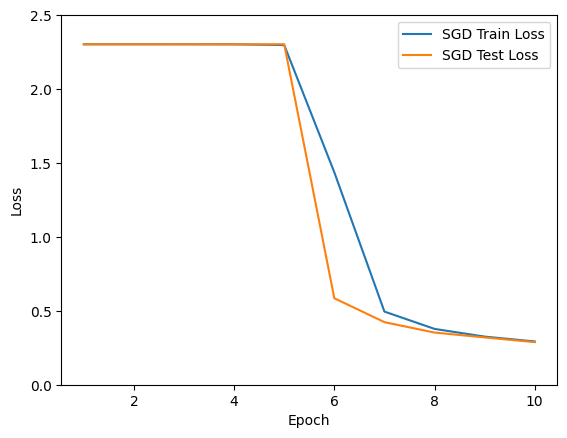

In [22]:
X = range(1, num_epochs+1)
plt.plot(X, train_losses, label="SGD Train Loss")
plt.plot(X, test_losses, label="SGD Test Loss")
plt.xticks(range(2, num_epochs+1, 2))
plt.legend()
plt.ylim(0, 2.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

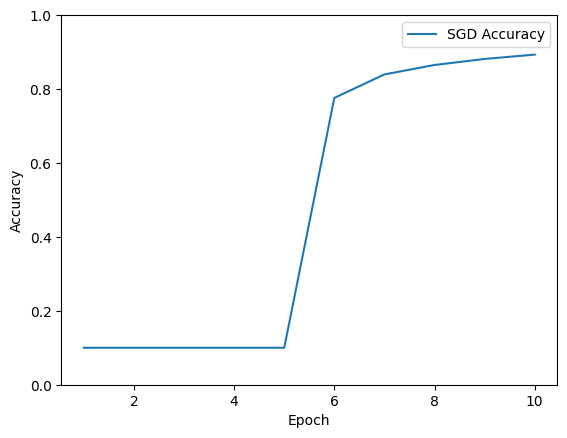

In [23]:
plt.plot(X, accuracies, label="SGD Accuracy")
plt.xticks(range(2, num_epochs+1, 2))
plt.legend()
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()